# Radial Basis Function Interpolation

In [17]:
%matplotlib notebook
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
# we'll need Matrix, UGrid, and Approximator
from etraj.etraj import Vector, Matrix, UGrid, Approximator, ScalarField
import etraj.etraj as et

In [18]:
# create a random one-dimensional grid
# between 0 and 1.
N = 25
x = np.random.uniform(0,1,N)

g = UGrid(x)

In [19]:
# generate the function values for f(x) = exp(x*cos(3pi*x)) - 1
f = np.exp(x*np.cos(3*np.pi*x)) - 1

<IPython.core.display.Javascript object>


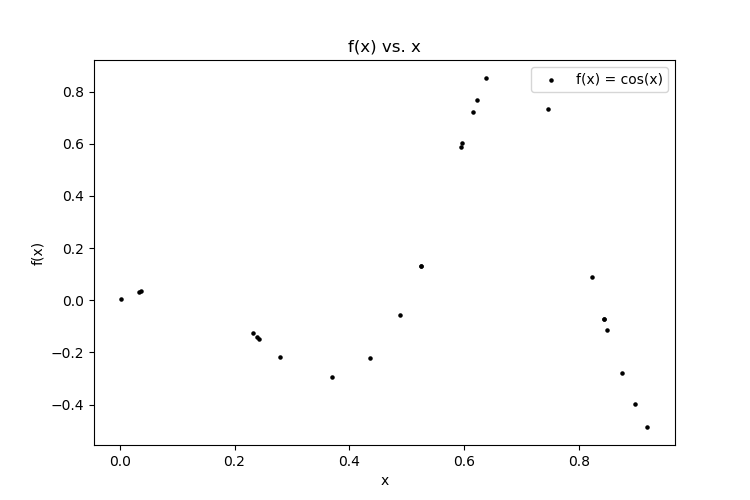

In [20]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 1')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [27]:
# create approximator
app = Approximator()
k = 24

# change approximator type to RBF
app.set_approx_type('RBF')
#app.set_shape(100)
app.set_k(k)

print(app)


Approximator type: Radial basis functions
Approximator parameters - k = 24
                          n = 3


Given the set of points in the grid $(x_1,\dots,x_N)$, we can construct the RBF matrix,

\begin{equation}
\mathbf{A} = \begin{bmatrix}
\varphi(||x_1 - x_1||) & \varphi(||x_1 - x_2||) & \varphi(||x_1 - x_3||) & \dots & \varphi(||x_1 - x_N||)\\
\varphi(||x_2 - x_1||) & \varphi(||x_2 - x_2||) & \varphi(||x_2 - x_3||) & \dots & \varphi(||x_2 - x_N||)\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
\varphi(||x_N - x_1||) & \varphi(||x_N - x_2||) & \varphi(||x_N - x_3||) & \dots & \varphi(||x_N - x_N||)
\end{bmatrix}
\end{equation}

In [28]:
# construct the RBF matrix for the neighbors of the point i_rand
rbf_matrix = app.construct_rbf_matrix(g)

print(rbf_matrix)

dim: (25x25), type: double&
[  1.000e+00   1.248e-01   9.961e-01   ...   ...   ...    6.377e-01   5.634e-01   9.997e-01
   1.248e-01   1.000e+00   1.488e-01   ...   ...   ...    5.510e-01   6.253e-01   1.186e-01
   9.961e-01   1.488e-01   1.000e+00   ...   ...   ...    6.908e-01   6.170e-01   9.936e-01
      ...         ...         ...      ...   ...   ...       ...         ...         ...
   6.377e-01   5.510e-01   6.908e-01   ...   ...   ...    1.000e+00   9.925e-01   6.228e-01
   5.634e-01   6.253e-01   6.170e-01   ...   ...   ...    9.925e-01   1.000e+00   5.485e-01
   9.997e-01   1.186e-01   9.936e-01   ...   ...   ...    6.228e-01   5.485e-01   1.000e+00  ]


Now we need to construct the vector of function values each point in the grid,

\begin{equation}
\mathbf{f}(x) = [f(x_1),f(x_2),\dots,f(x_N)].
\end{equation}

In [29]:
# create the vector of function values for each point
v = Vector("f_vec",f)

print(v)

dim: 25, type: double&, name: 'f_vec'
[ -7.133e-02  -2.940e-01   9.014e-02   ...    7.689e-01   5.866e-01  -1.131e-01  ]


Now we wish to solve the least squares problem,

\begin{equation}
\begin{bmatrix}
\varphi(||x_1 - x_1||) & \varphi(||x_1 - x_2||)  & \dots & \varphi(||x_1 - x_N||)\\
\varphi(||x_2 - x_1||) & \varphi(||x_2 - x_2||) & \dots & \varphi(||x_2 - x_N||)\\
\vdots & \vdots  & \ddots & \vdots\\
\varphi(||x_N - x_1||) & \varphi(||x_N - x_2||)  & \dots & \varphi(||x_N - x_N||)
\end{bmatrix}\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_N\end{bmatrix} = \begin{bmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_N)\end{bmatrix},
\end{equation}

for the weights,

\begin{equation}
\mathbf{w}(x) = [w_1,w_2,\dots,w_N].
\end{equation}

In [30]:
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
w = et.dgels(rbf_matrix,v)

print(w)

dim: 25, type: double&
[  7.142e+11  -6.662e+10   2.056e+11   ...   -2.857e+11  -1.739e+11  -9.124e+11  ]


With the weight vector $\mathbf{w}(x)$, we can compute approximate function values for any point $x$ via,

\begin{equation}
s(x) = \sum_{i=1}^{N}w_i\varphi(||x - x_i||).
\end{equation}

In [31]:
# Let's use our interpolation to find function values of a random set.
y = np.random.uniform(0,1,N)
s = []
for i in range(len(y)):
    # construct the rbf vector
    rbf_vector = app.construct_rbf_vector(g,[y[i]])
    # find the function value
    s.append(w.dot(rbf_vector))

<IPython.core.display.Javascript object>


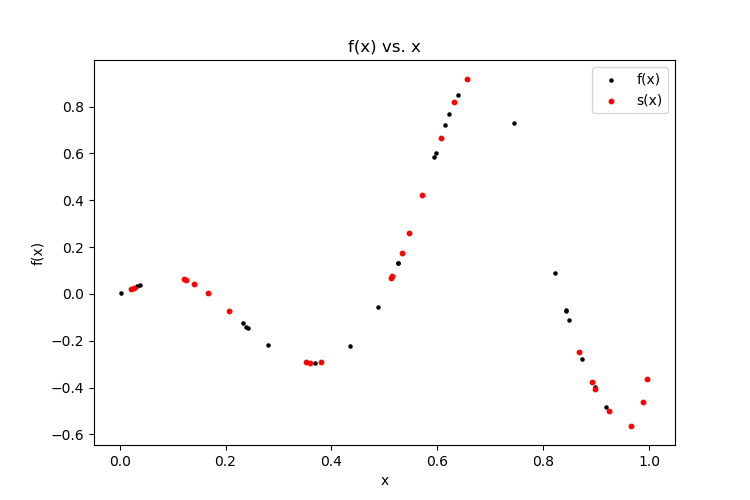

In [32]:
# let's plot these new interpolated points
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 2')
axs.scatter(x,f,color='k',label='f(x)',s=5)
axs.scatter(y,s,color='r',label='s(x)',s=10)
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [5]:
# consider a random point in our grid
i_rand = np.random.randint(len(x))
x_rand, f_rand = x[i_rand], f[i_rand]

print("Random index: ",i_rand)
print("Random point: ",x_rand)
print("Random f(x):  ",f_rand)

Random index:  24
Random point:  0.9425083244619147
Random f(x):   -0.554029079994367


<IPython.core.display.Javascript object>


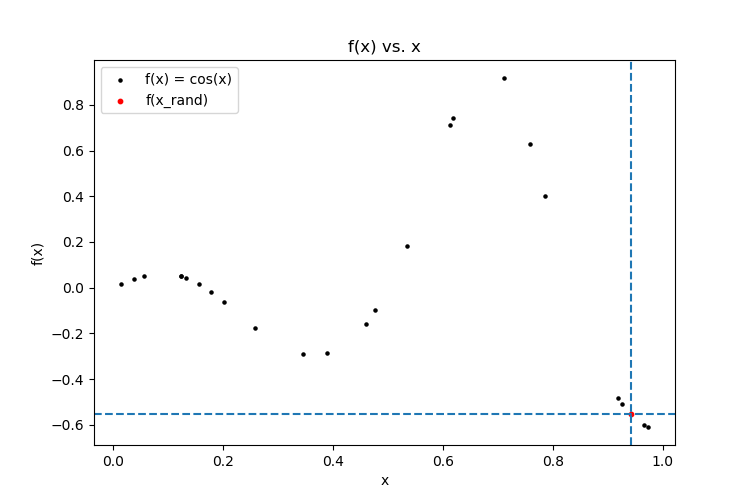

In [6]:
# lets plot that point
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 2')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)',s=10)
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [52]:
# select a number of nearest neighbors to use for the point
k = 10
g.query_neighbors(k)
# grab the nearest neighbors to the point x_rand
neighbors = g.get_neighbors(i_rand)

print("indices of the %s nearest neighbors to the point %s:" % (k,i_rand))
print(neighbors)

indices of the 10 nearest neighbors to the point 75:
[75, 50, 14, 3, 71, 73, 30, 29, 27, 24]


In [53]:
# grab the x and f values for those neighbors
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]

print("x values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(x_neighbors)
print("f(x) values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(f_neighbors)

x values for the 10 nearest neighbors to the point 0.8454341070908211:
[0.8454341070908211, 0.8517390373942649, 0.8548307609919606, 0.8563655415472362, 0.856616243439632, 0.8331579848667767, 0.8249638751114261, 0.8694737968052841, 0.8205796168625044, 0.8713430386111543]
f(x) values for the 10 nearest neighbors to the point 0.8454341070908211:
[-0.09172713381135755, -0.1367155135696415, -0.1580321414557312, -0.16842828832709422, -0.17011466563235733, 0.001377841577370198, 0.06716534702078492, -0.25208282854204245, 0.10340086028893869, -0.2632526712928487]


<IPython.core.display.Javascript object>


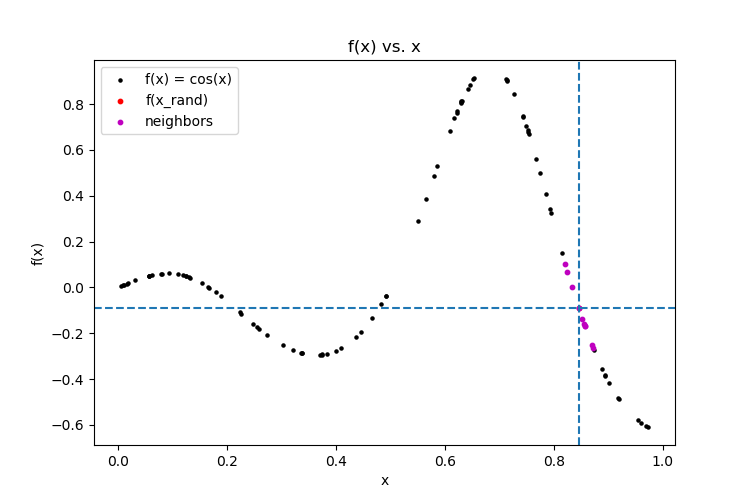

In [54]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 3')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)',s=10)
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors',s=10)
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [59]:
# now we can construct a derivative matrix for the set of points
# in neighbors
rbfd_matrix = app.construct_rbfd_matrix(g,neighbors,i_rand)

print(rbfd_matrix)

dim: (10x10), type: double&
[  -0.000e+00  -8.474e-01  -7.772e-01   ...   ...   ...   -1.486e-02  -1.032e-02  -6.298e-03
  -8.474e-01   -0.000e+00  -5.620e-01   ...   ...   ...   -1.527e-01  -3.785e-04  -8.401e-02
  -7.772e-01  -5.620e-01   -0.000e+00   ...   ...   ...   -3.431e-01  -5.506e-05  -2.161e-01
      ...         ...         ...      ...   ...   ...       ...         ...         ...
  -1.486e-02  -1.527e-01  -3.431e-01   ...   ...   ...    -0.000e+00  -4.054e-10  -3.610e-01
  -1.032e-02  -3.785e-04  -5.506e-05   ...   ...   ...   -4.054e-10   -0.000e+00  -6.533e-11
  -6.298e-03  -8.401e-02  -2.161e-01   ...   ...   ...   -3.610e-01  -6.533e-11   -0.000e+00  ]


In [60]:
# From here, the first derivative at each point in the
# neighborhood is given by
fd_app = et.dgemv(1.0,rbfd_matrix,f_app)

print(fd_app)

dim: 10, type: double&, name: '1.000000 *   *  '
[  3.151e-02   4.372e-01  -1.916e+00   ...    5.271e-01   4.905e-02  -4.270e-02  ]


In [61]:
# the first derivative of the point of interest
# is the first entry

# the y-intercept of the tangent vector is
f_0 = -fd_app[0]*x_rand + f_rand
# while the slope is
f_1 = fd_app[0]

print("The tangent vector of f(x) at %s is:" % x_rand)
print("<x, %.2f*x + %.2f>" % (f_1,f_0))

The tangent vector of f(x) at 0.8454341070908211 is:
<x, 0.03*x + -0.12>


<IPython.core.display.Javascript object>


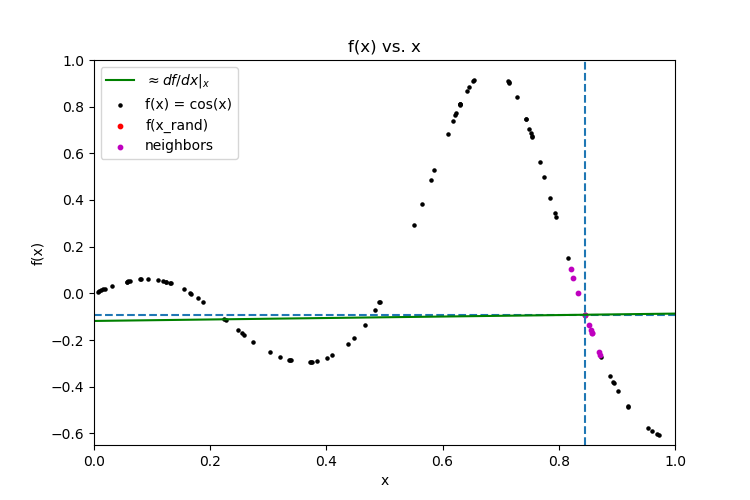

In [62]:
# generate a set of points for the line
x_lin = np.asarray([-np.pi,np.pi])
tangent = f_1*x_lin + f_0
# now to plot it with the neighbors
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 4')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)',s=10)
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors',s=10)
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(0,1)
axs.set_ylim(-.65,1.0)
plt.legend()
plt.show()